# Notícias G1 - 7. Classificação com ELS

Utilizaremos query string com o termo more_like_this para simular uma classificação através de uma consulta ao Elastic Search. Dada a notícia cuja categoria é desconhecida, o Elastic Search irá procurar notícias semelhantes e usaremos a classificação destas para inferir a da notícia a ser classificada.

## Imports:

Importes de bibliotecas usadas com frequência no código.

In [213]:
import pandas as pd
import numpy as np

## Conectando ao Elastic Search:

Estabelecendo a conexão para realizar as operações no banco de dados.

In [214]:
!pip install elasticsearch
import elasticsearch
client = elasticsearch.Elasticsearch('localhost:9200')
client.info()

{'name': 'elastic_node01',
 'cluster_name': 'docker-cluster',
 'cluster_uuid': 'euW7vXsqSruqSHXTKey9IQ',
 'version': {'number': '7.9.2',
  'build_flavor': 'default',
  'build_type': 'docker',
  'build_hash': 'd34da0ea4a966c4e49417f2da2f244e3e97b4e6e',
  'build_date': '2020-09-23T00:45:33.626720Z',
  'build_snapshot': False,
  'lucene_version': '8.6.2',
  'minimum_wire_compatibility_version': '6.8.0',
  'minimum_index_compatibility_version': '6.0.0-beta1'},
 'tagline': 'You Know, for Search'}

## Recuperando Registros com Categoria:

Query para recuperar da base as notícias cujas categorias são conhecidas.

In [215]:
query_string = {
    "query": {
        "bool": {
            "must_not": {
                "term": {
                    "categoria": "FALTANDO"
                }
            }
        }
    }
}

results = client.search(index=index_name, body=query_string, size=1500)
print(f"Encontrado {results['hits']['total']['value']} resultados")

Encontrado 909 resultados


In [216]:
# extraindo os documentos do índice
documents = [hit['_source'] for hit in results['hits']['hits']] 

# convertendo a lista de dicionários numa dataframe
noticias_conhecidas = pd.DataFrame.from_records(documents)

noticias_conhecidas

,titulo,url,texto,categoria,texto_tratado
0,Senado aprova projeto que criminaliza o 'stalk...,https://g1.globo.com/politica/noticia/2021/03/...,O Senado aprovou em sessão remota nesta terça...,politica,senado aprova projeto que criminaliza o stalki...
1,ANA FLOR: Lula elegível pode ser pá de cal na ...,https://g1.globo.com/economia/blog/ana-flor/po...,A mera possibilidade do ex-presidente Luiz In...,economia,ana flor lula elegvel pode ser p de cal na ver...
2,Nº de leitos para Covid pagos pelo Ministério ...,https://g1.globo.com/bemestar/noticia/2021/03/...,O número de leitos de UTI exclusivos para pac...,bemestar,n de leitos para covid pagos pelo ministrio da...
3,Ministro da Infraestrutura fala em adotar medi...,https://g1.globo.com/economia/noticia/2021/03/...,"O ministro da Infraestrutura, Tarcísio de Fre...",economia,ministro da infraestrutura fala em adotar medi...
4,"Exportação de carne suína do Brasil cresceu 6,...",https://g1.globo.com/economia/agronegocios/not...,As exportações de carne suína do Brasil ating...,economia,exportao de carne suna do brasil cresceu no ...
...,...,...,...,...,...
904,Veja se é possível obter a localização de algu...,https://g1.globo.com/economia/tecnologia/blog/...,Se você tem alguma dúvida sobre segurança da ...,economia,veja se possvel obter a localizao de algum pe...
905,Senado: proposta de fim do piso de saúde e edu...,https://g1.globo.com/politica/noticia/2021/02/...,Líderes partidários do Senado ouvidos pelo G1...,politica,senado proposta de fim do piso de sade e educa...
906,Bolsonaro edita decreto que obriga posto a inf...,https://g1.globo.com/economia/noticia/2021/02/...,Um decreto editado pelo presidente Jair Bolso...,economia,bolsonaro edita decreto que obriga posto a inf...
907,Concurso IBGE/Censo 2021: inscrições para mais...,https://g1.globo.com/economia/concursos-e-empr...,Quem pretende se candidatar a uma das 181.898...,economia,concurso ibgecenso inscries para mais de mil...


## Recuperando Registros sem Categoria:

Query para recuperar todos os registros sem categoria conhecida, ou seja, notícias que precisamos classificar.

In [217]:
query_string = {
    "query": {
        "term": {"categoria": "FALTANDO"}
    }
}

results = client.search(index=index_name, body=query_string, size=1500)
print(f"Encontrado {results['hits']['total']['value']} resultados")

Encontrado 1044 resultados


In [218]:
# extraindo os documentos do índice
documents = [hit['_source'] for hit in results['hits']['hits']] 

# convertendo a lista de dicionários numa dataframe
noticias_desconhecidas = pd.DataFrame.from_records(documents)

noticias_desconhecidas

,titulo,url,texto,categoria,texto_tratado
0,Governo de SP estuda paralisar o Campeonato Pa...,https://globoesporte.globo.com/sp/futebol/camp...,O governo do Estado de São Paulo estuda paral...,FALTANDO,governo de sp estuda paralisar o campeonato pa...
1,Coroa britânica diz que acusações de racismo s...,https://g1.globo.com/mundo/noticia/2021/03/09/...,"A família real britânica disse, nesta terça-f...",FALTANDO,coroa britnica diz que acusaes de racismo sero...
2,Eike e mais 6 são denunciados por manipulação ...,https://g1.globo.com/rj/rio-de-janeiro/noticia...,O Ministério Público Federal (MPF) denunciou ...,FALTANDO,eike e mais so denunciados por manipulao de m...
3,Pedido de ajuda? Vídeo mostra cão ferido entra...,https://g1.globo.com/ce/ceara/noticia/2021/03/...,Um cachorro vira-lata entrou sozinho em uma c...,FALTANDO,pedido de ajuda vdeo mostra co ferido entrando...
4,Mato Grosso segue sem conseguir transferir pac...,https://g1.globo.com/mt/mato-grosso/noticia/20...,A fila de pacientes que esperam por leito de ...,FALTANDO,mato grosso segue sem conseguir transferir pac...
...,...,...,...,...,...
1039,Polícia Federal de Campinas faz operação contr...,https://g1.globo.com/sp/campinas-regiao/notici...,A Polícia Federal (PF) de Campinas (SP) defla...,FALTANDO,polcia federal de campinas faz operao contra f...
1040,"Butantan entrega 1,2 milhão de doses da Corona...",https://g1.globo.com/sp/sao-paulo/noticia/2021...,O Instituto Butantan entrega nesta terça-feir...,FALTANDO,butantan entrega milho de doses da coronavac ...
1041,Países do G7 condenam violência contra manifes...,https://g1.globo.com/mundo/noticia/2021/02/23/...,Os ministros das Relações Exteriores dos país...,FALTANDO,pases do g condenam violncia contra manifestan...
1042,Empreendedorismo formal gera vantagens e oport...,https://g1.globo.com/sp/presidente-prudente-re...,Partir para um negócio próprio é a saída que ...,FALTANDO,empreendedorismo formal gera vantagens e oport...


## Método para Classificação da Notícia pelo Elastic:

Realiza uma query com o termo more_like_this para encontrar notícias semelhantes entre a massa de notícias com categorias conhecidas, a fim de utilizar estas categorias para a classificação.

In [239]:
def classificar(index_name, text, size=10, fields=['_source']):
    query = {
        "query": {
            "bool": {
                "must_not": {
                    "term": {
                        "categoria": "FALTANDO"
                    }
                },
                "must": {
                    "more_like_this": {
                        "fields": fields,
                        "like": text,
                        "min_term_freq": 1,
                        "max_query_terms": 40,
                    }
                }
            }
        },
    }
    
    return client.search(index=index_name, body=query, size=size)

## Método para Processamento das Notícias:

Processa a massa de notícias a serem classificadas. Para cada notícia de categoria desconhecida, serão selecionadas 50 notícias de categoria conhecida. Em seguida, será averiguado qual a categoria de maior frequência entre as 50 selecionadas. Essa categoria de maior frequência será utilizada para a classificação.

In [246]:
import operator

def processar_massa (data):

    classificacao = []

    for index in data.index:

        noticia = data.loc[index]
        response = classificar(index_name, noticia.texto_tratado, 50, ['texto_tratado'])
        counter = Counter([hit['_source']['categoria'] for hit in response['hits']['hits']])

        if bool(counter):
            classificacao.append(max(counter.items(), key=operator.itemgetter(1))[0])
        else:
            classificacao.append("FALTANDO")

        #print(response['hits']['hits'][0]['_source']['categoria'])
        #print([hit['_source']['categoria'] for hit in response['hits']['hits']])
        
    return classificacao

## Processando Massa de Teste e Medindo Desempenho:

Será processada a massa de notícias com categoria conhecida para realização de teste e aferição de desempenho pela métrica da acurácia.

In [247]:
classificacao = processar_massa(noticias_conhecidas)
sum([c==t for c, t in zip(classificacao, noticias_conhecidas['categoria'])])/len(classificacao)

0.8932893289328933

A acurácia da massa de teste foi bastante alta, o que demostra a eficiência do método aplicado.

## Classificando Notícias de Categoria Desconhecida:

O método de classificação será aplicado à massa de notícias sem categorias conhecidas.

In [251]:
classificacao = processar_massa(noticias_desconhecidas)
len(classificacao)

1044

## Análise dos Resultados: Distribuição por Categoria

Será apresentado gráfico que demonstra a distribuição dos dados por categoria.

/Users/edprata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  if __name__ == '__main__':


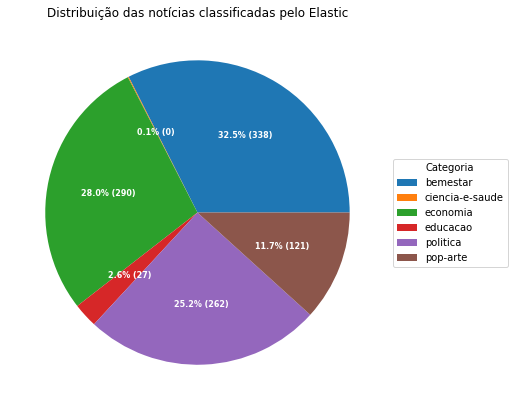

In [252]:
import matplotlib.pyplot as plt

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d})".format(pct, absolute)

def pie(title, legend, data, label):
  fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(aspect="equal"))
  wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data), textprops=dict(color="w"))
  ax.legend(wedges, label, title=legend, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
  plt.setp(autotexts, size=8, weight="bold")
  ax.set_title(title)
  plt.show()

from collections import Counter
counter = sorted(Counter(classificacao).items(), key=lambda i: i[0])
ordered = (pd.DataFrame(counter, columns=['cat', 'valor'])).drop([0])
title = "Distribuição das notícias classificadas pelo Elastic"
pie(title, "Categoria", ordered[['valor']].values, (ordered['cat']).values)

## Análise de Resultados: Verificação por Amostragem:

Análise manual de uma amostra dos dados para verificar a eficiência da classificação.

### Incluindo a classificação no DataFrame de notícias:

As categorias obtidas pela classificação serão incorporadas ao DataFrame com as notícias.

In [254]:
noticias_desconhecidas['categoria'] = classificacao
noticias_desconhecidas

,titulo,url,texto,categoria,texto_tratado
0,Governo de SP estuda paralisar o Campeonato Pa...,https://globoesporte.globo.com/sp/futebol/camp...,O governo do Estado de São Paulo estuda paral...,politica,governo de sp estuda paralisar o campeonato pa...
1,Coroa britânica diz que acusações de racismo s...,https://g1.globo.com/mundo/noticia/2021/03/09/...,"A família real britânica disse, nesta terça-f...",pop-arte,coroa britnica diz que acusaes de racismo sero...
2,Eike e mais 6 são denunciados por manipulação ...,https://g1.globo.com/rj/rio-de-janeiro/noticia...,O Ministério Público Federal (MPF) denunciou ...,economia,eike e mais so denunciados por manipulao de m...
3,Pedido de ajuda? Vídeo mostra cão ferido entra...,https://g1.globo.com/ce/ceara/noticia/2021/03/...,Um cachorro vira-lata entrou sozinho em uma c...,economia,pedido de ajuda vdeo mostra co ferido entrando...
4,Mato Grosso segue sem conseguir transferir pac...,https://g1.globo.com/mt/mato-grosso/noticia/20...,A fila de pacientes que esperam por leito de ...,bemestar,mato grosso segue sem conseguir transferir pac...
...,...,...,...,...,...
1039,Polícia Federal de Campinas faz operação contr...,https://g1.globo.com/sp/campinas-regiao/notici...,A Polícia Federal (PF) de Campinas (SP) defla...,politica,polcia federal de campinas faz operao contra f...
1040,"Butantan entrega 1,2 milhão de doses da Corona...",https://g1.globo.com/sp/sao-paulo/noticia/2021...,O Instituto Butantan entrega nesta terça-feir...,bemestar,butantan entrega milho de doses da coronavac ...
1041,Países do G7 condenam violência contra manifes...,https://g1.globo.com/mundo/noticia/2021/02/23/...,Os ministros das Relações Exteriores dos país...,politica,pases do g condenam violncia contra manifestan...
1042,Empreendedorismo formal gera vantagens e oport...,https://g1.globo.com/sp/presidente-prudente-re...,Partir para um negócio próprio é a saída que ...,economia,empreendedorismo formal gera vantagens e oport...


### Verificando amostra de resultados:

Aqui é selecionado aleatóriamente uma quantidade de notícias que foi analisada visualmente para constatar se a classificação dada foi ou não coerente.

In [257]:
def show(index, avaliacao):
  noticia = noticias_desconhecidas.loc[index]
  print(index, noticia['categoria'], avaliacao)
  print(noticia['titulo'])
  print(noticia['texto'])

y = 0
for x in [30, 79, 103, 171, 205, 247, 315, 374, 409, 467, 515, 581, 607, 658, 719, 754, 811, 888, 933, 967, 1023]:
  show(x, avaliacao[y])
  y = y + 1
  print('')

30 economia Unknow
Protestos pelo Dia Internacional da Mulher são registrados no mundo; veja fotos
 Grandes marchas de mulheres aconteceram em diversas partes do mundo neste 8 de março.  Mesmo em meio à pandemia do coronavírus, manifestantes usaram máscaras e saíram às ruas pedindo pelo fim da violência sexual, contra as desigualdades e em defesa do direito ao aborto seguro.  Em Paris, centenas marcharam pelas ruas no centro da cidade com cartazes e lenços roxos, cor que identifica a luta feminista.  Os eventos que marcam o Dia Internacional da Mulher acontecem no mundo inteiro.  Veja imagens de protestos, eventos e marchas ao redor do mundo: 

79 economia Unknow
Homem é baleado após tentar impedir assédio em ônibus em São Gonçalo
 Patrick Motta Brandão, de 29 anos, foi baleado na tarde desta sexta-feira (5) quando tentou impedir que uma mulher fosse assediada dentro de um ônibus em Tribobó, São Gonçalo, Região Metropolitana do Rio.  Segundo informações da Polícia Militar, um homem ain

### Classificando a amostra:

Nesse ponto criamos um vetor com o resultado da avaliação visual classificando cada registro como uma seguintes opções:

* Desconhecida: Significa que a notícia é de uma categoria não conhecida pelo modelo, pois não estava representada na massa de treino. Exemplos desse caso são notícias sobre segurança pública e saúde que não estava presente ou pelo menos não estava classificada na massa de treino.
* NOK: São as notícias que o modelo de fato classificou errado, pois havia categoria compatível, mas ele classificou de forma incorreta.
* OK: São as notícias classificadas corretamente.

In [1]:
avaliacao = ['Desconhecida', 'Desconhecida', 'OK', 'OK', 'Desconhecida', 
             'OK', 'NOK', 'OK', 'OK', 'NOK', 'OK', 'NOK', 
             'OK', 'OK', 'OK', 'NOK', 'OK', 'OK', 'Desconhecida', 
             'OK', 'OK']


### Medindo o Desempenho:

Será usada a acurácia como medida de desempenho da amostra.

In [259]:
sum([a=='OK' for a in avaliacao])/len(avaliacao)

0.6190476190476191

### Distribuição da Amostra Verificada:

Gráfico com a distribuição do resultado da avaliação dos dados por amostragem.

/Users/edprata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  if __name__ == '__main__':


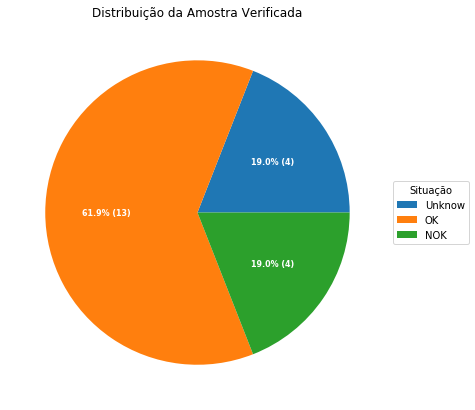

In [258]:
# Distribuição da Amostra Verificada:
counter = pd.DataFrame(Counter(avaliacao).items(), columns=['status', 'value'])
title = "Distribuição da Amostra Verificada"
pie(title, "Situação", counter[['value']], (counter['status']).values)